
# <center> CSCI 395 - Program 2 <center>
### <center> Hunter College <center>
### <center> Jose Ortiz
### <center> Prof. Adrián Soto Cambres
### <center> Date: 02/27/2025


## Dataset
We'll use NYC school data from:
- [2021 DOE High School Directory](https://data.cityofnewyork.us/Education/2021-DOE-High-School-Directory/8b6c-7uty)
- [2020 DOE High School Directory](https://data.cityofnewyork.us/Education/2020-DOE-High-School-Directory/23z9-6uk9)
- [2019 DOE High School Directory](https://data.cityofnewyork.us/Education/2019-DOE-High-School-Directory/uq7m-95z8)

Sample datasets included in repo:
- `2021_DOE_High_School_Directory_SI.csv`: Staten Island schools
- `2020_DOE_High_School_Directory_late_start.csv`: Schools with 9am start times

Necessary Libraries for the Program to run.

## Section 0: Setup
Function templates:

In [126]:
# libraries for data manipulation
import numpy as np
import pandas as pd

# libraries for data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# jupyter extension to render charts inline
%matplotlib inline

In [127]:
import pandas as pd

def import_data(file_name):
    """Read relevant data from DOE High School Directory CSV file."""
    cols = [
        "dbn", "school_name", "borocode", "NTA", "graduation_rate",
        "pct_stu_safe", "attendance_rate", "college_career_rate",
        "language_classes", "advancedplacement_courses"
    ]
    df = pd.read_csv(file_name, usecols=cols)
    df = df.dropna(subset=['graduation_rate'])
    return df

def impute_numeric_cols_median(df):
    """Impute missing numeric values with column median."""
    numeric_cols = ['pct_stu_safe', 'attendance_rate', 'college_career_rate']
    for col in numeric_cols:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
    return df

def compute_item_count(df, col):
    """Count the number of items separated by commas in each entry."""
    return df[col].fillna('').apply(lambda x: len([i for i in x.split(',') if i.strip() != '']))

def encode_categorical_col(x):
    """One-hot encode a categorical column using pandas get_dummies."""
    return pd.get_dummies(x)

def split_test_train(df, x_col_names, y_col_name, frac=0.25, random_state=922):
    """Split data into train and test subsets."""
    test_df = df.sample(frac=frac, random_state=random_state)
    train_df = df.drop(test_df.index)
    x_train = train_df[x_col_names]
    x_test = test_df[x_col_names]
    y_train = train_df[y_col_name]
    y_test = test_df[y_col_name]
    return (x_train, x_test, y_train, y_test)


## Section 1: Data Ingestion & Feature Engineering
### Example Usage
Load Staten Island data:

In [128]:
file_name = '2021_DOE_High_School_Directory_SI.csv'
si_df = import_data(file_name)
print(f'There are {len(si_df.columns)} columns:')
print(si_df.columns)
print('The dataframe is:')
print(si_df)

There are 10 columns:
Index(['dbn', 'school_name', 'borocode', 'language_classes',
       'advancedplacement_courses', 'graduation_rate', 'pct_stu_safe',
       'attendance_rate', 'college_career_rate', 'NTA'],
      dtype='object')
The dataframe is:
       dbn                                        school_name borocode  \
1   31R047          CSI High School for International Studies        R   
2   31R064        Gaynor McCown Expeditionary Learning School        R   
3   31R080                    Michael J. Petrides School, The        R   
4   31R440                               New Dorp High School        R   
5   31R445                          Port Richmond High School        R   
6   31R450                                 Curtis High School        R   
7   31R455                            Tottenville High School        R   
8   31R460                        Susan E. Wagner High School        R   
9   31R600  Ralph R. McKee Career and Technical Education ...        R   
10  31R60

**Expected Output**:
```
There are 10 columns:
Index(['dbn', 'school_name', 'borocode', 'NTA', 'graduation_rate', 'pct_stu_safe',
       'attendance_rate', 'college_career_rate', 'language_classes',
       'advancedplacement_courses'],
      dtype='object')
The dataframe is:
      dbn                                        school_name  ...
1  31R047          CSI High School for International Studies  ...
2  31R064        Gaynor McCown Expeditionary Learning School  ...
[10 rows x 10 columns]
```

Note that there are 11 high schools in Staten Island, but one (Eagle Academy) was new and didn't have a graduation rate, so it was dropped.

If you examine the 2020 schools that have a late start (after 9am) 2020_DOE_High_School_Directory_late_start.csv

In [129]:
file_name = '2020_DOE_High_School_Directory_late_start.csv'
late_df = import_data(file_name)
print('The numerical columns are:')
print(late_df[['dbn','pct_stu_safe','attendance_rate','college_career_rate']])

The numerical columns are:
       dbn  pct_stu_safe  attendance_rate  college_career_rate
0   01M696          0.92             0.95                 0.92
1   07X334          0.89             0.90                 0.35
2   02M543          0.92             0.84                 0.75
3   14K685          0.94             0.83                 0.42
4   02M546          0.80             0.90                 0.78
5   02M376          0.97             0.93                 0.79
6   19K404          0.87             0.86                 0.74
7   20K490          0.80             0.90                 0.57
9   27Q334          0.92             0.83                  NaN
10  30Q301          0.94             0.93                 0.84
11  28Q328          0.87             0.87                 0.88
12  14K561          0.94             0.89                 0.76
13  31R450          0.76             0.85                 0.60
14  02M298          0.89             0.87                 0.65
15  04M555          0.97    

There are several missing values in the college_career_rate column. Fill those in (impute) with the median of the column:

In [130]:
late_df = impute_numeric_cols_median(late_df)
print(late_df[['dbn','pct_stu_safe','attendance_rate','college_career_rate']])

       dbn  pct_stu_safe  attendance_rate  college_career_rate
0   01M696          0.92             0.95                0.920
1   07X334          0.89             0.90                0.350
2   02M543          0.92             0.84                0.750
3   14K685          0.94             0.83                0.420
4   02M546          0.80             0.90                0.780
5   02M376          0.97             0.93                0.790
6   19K404          0.87             0.86                0.740
7   20K490          0.80             0.90                0.570
9   27Q334          0.92             0.83                0.725
10  30Q301          0.94             0.93                0.840
11  28Q328          0.87             0.87                0.880
12  14K561          0.94             0.89                0.760
13  31R450          0.76             0.85                0.600
14  02M298          0.89             0.87                0.650
15  04M555          0.97             0.95              

Now, using the compute_item_count twice, add two new columns with counts for languages & AP classes:

In [131]:
late_df['language_count'] = compute_item_count(late_df,'language_classes')
late_df['ap_count'] = compute_item_count(late_df,'advancedplacement_courses')
print('High schools that have 9am or later start:')
print(late_df[['dbn','language_count','language_classes','ap_count','advancedplacement_courses']])

High schools that have 9am or later start:
       dbn  language_count                                   language_classes  \
0   01M696               5            French, Greek, Latin, Mandarin, Spanish   
1   07X334               1                                             French   
2   02M543               1                                            Spanish   
3   14K685               1                                            Spanish   
4   02M546               1                                            Spanish   
5   02M376               1                                            Spanish   
6   19K404               1                                            Spanish   
7   20K490               6  Arabic, French, Greek, Italian, Mandarin, Spanish   
9   27Q334               1                                            Spanish   
10  30Q301               1                                             French   
11  28Q328               2                                    Fren

Now add columns for the borough code, using one hot encoding:

In [132]:
boros_df = encode_categorical_col(late_df['borocode'])
print(late_df['borocode'].head(5))
print(boros_df.head(5))

0    M
1    X
2    M
3    K
4    M
Name: borocode, dtype: object
       K      M      Q      R      X
0  False   True  False  False  False
1  False  False  False  False   True
2  False   True  False  False  False
3   True  False  False  False  False
4  False   True  False  False  False


Gives a new DataFrame with 0 and 1 values. Check your work by counting number of schools in each borough:

In [133]:
print('Number of schools in each borough:')
print(boros_df.sum(axis=0))

Number of schools in each borough:
K    9
M    8
Q    6
R    1
X    4
dtype: int64


Shortly we will be building linear models. To be able to validate them, we randomly split the dataset into training and testing sets. If you apply your function split_train_test() to the late schools dataset to predict "graduation_rate" using the numerical columns only:

In [134]:
x_cols = ['language_count','ap_count','pct_stu_safe','attendance_rate','college_career_rate']
y_col = 'graduation_rate'
x_train, x_test, y_train, y_test = split_test_train(late_df, x_cols, y_col)
print(f'The sizes of the sets are:')
print(f'x_train has {len(x_train)} rows.\tx_test has {len(x_test)} rows.')
print(f'y_train has {len(y_train)} rows.\ty_test has {len(y_test)} rows.')

The sizes of the sets are:
x_train has 21 rows.	x_test has 7 rows.
y_train has 21 rows.	y_test has 7 rows.


## Section 2: Training a Linear Regressor
Function templates:

In [135]:
def compute_lin_reg(x, y):
    """Compute slope and intercept for 1D linear regression."""
    sd_x = x.std()
    sd_y = y.std()
    r = x.corr(y)
    theta_1 = r * (sd_y / sd_x)
    theta_0 = y.mean() - theta_1 * x.mean()
    return (theta_0, theta_1)

# Example usage for Section 2
if False:
    si_df['language_count'] = compute_item_count(si_df, 'language_classes')
    si_df['ap_count'] = compute_item_count(si_df, 'advancedplacement_courses')
    x_cols = ['language_count', 'ap_count', 'pct_stu_safe', 'attendance_rate', 'college_career_rate']
    coeff = {}
    for col in x_cols:
        coeff[col] = compute_lin_reg(si_df[col], si_df['graduation_rate'])
        print(f'For {col}, theta_0 = {coeff[col][0]}, theta_1 = {coeff[col][1]}')


Continuing our example for the late start high schools, if you build a series of 1-d linear regression models, one for each numeric variable:

In [136]:
x_cols = ['language_count', 'ap_count', 'pct_stu_safe', 'attendance_rate', 'college_career_rate']
coeff = {}
for col in x_cols:
    coeff[col] = compute_lin_reg(x_train[col], y_train)
    print(f'For {col}, theta_0 = {coeff[col][0]} and theta_1 = {coeff[col][1]}')

For language_count, theta_0 = 0.821969696969697 and theta_1 = 0.00872159090909091
For ap_count, theta_0 = 0.829236532747707 and theta_1 = 0.0021805968221160063
For pct_stu_safe, theta_0 = 0.3259265268281376 and theta_1 = 0.5869741569127362
For attendance_rate, theta_0 = -0.4082696527688132 and theta_1 = 1.4385568607202786
For college_career_rate, theta_0 = 0.4664578537197912 and theta_1 = 0.5575944180964912


We can now use the coefficients of the models to make predictions.

## Section 3: Model Evaluation
### Example Model Comparison
```
                     train_loss  test_loss
language_count         0.015100   0.010848
ap_count               0.015115   0.009148
pct_stu_safe           0.013934   0.005853
attendance_rate        0.008011   0.006838
college_career_rate    0.005345   0.001625
```

In [137]:
# Section 3: Model Evaluation

def predict(x, theta_0, theta_1):
    """Make predictions using linear model."""
    return theta_0 + theta_1 * x

def mse_loss(y_actual, y_estimate):
    """Compute Mean Squared Error."""
    return ((y_actual - y_estimate) ** 2).mean()

def rmse_loss(y_actual, y_estimate):
    """Compute Root Mean Squared Error."""
    return mse_loss(y_actual, y_estimate) ** 0.5

def compute_loss(y_actual, y_estimate, loss_fnc=mse_loss):
    """Compute specified loss function."""
    return loss_fnc(y_actual, y_estimate)


Once you have implemented those functions, you can check your work by continuing your example of the set of models to predict graduation rate. Check which explanatory variable did best on the testing data:

In [138]:
# loop through all the models, computing train and test loss
y_train_predictions = {}
y_test_predictions = {}
train_losses = {}
test_losses = {}
min_loss = 1e09
for col in x_cols:
    theta_0, theta_1 = coeff[col]
    y_train_predictions[col] = predict(x_train[col], theta_0, theta_1)
    y_test_predictions[col] = predict(x_test[col], theta_0, theta_1)

    train_losses[col] = compute_loss(y_train, y_train_predictions[col])
    test_losses[col] = compute_loss(y_test, y_test_predictions[col])

# arrange models' train and test losses into a dataframe
losses_df = pd.DataFrame(
    index=x_cols,
    data={
        "train_loss": train_losses.values(),
        "test_loss": test_losses.values(),
    }
)
print(losses_df)

                     train_loss  test_loss
language_count         0.015100   0.010848
ap_count               0.015115   0.009148
pct_stu_safe           0.013934   0.005853
attendance_rate        0.008011   0.006838
college_career_rate    0.005345   0.001625


## Visualization Example
```python
import matplotlib.pyplot as plt
def graph_data(df, col, coeff):
    plt.scatter(df[col], df['graduation_rate'], label='Actual')
    predict_grad = predict(df[col], coeff[col][0], coeff[col][1])
    plt.scatter(df[col], predict_grad, label='Predicted')
    plt.title(f'{col} vs graduation_rate')
    plt.ylabel('graduation_rate')
    plt.xlabel(f'{col}')
    plt.legend()
    plt.show()

# graph_data(late_df, 'college_career_rate', coeff)
```
Expected output shows actual vs predicted values plot.

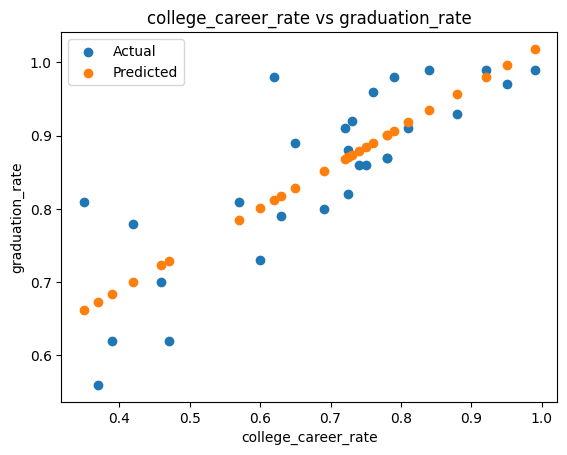

In [139]:
import matplotlib.pyplot as plt

def graph_data(df, col, coeff):

    plt.scatter(df[col], df['graduation_rate'], label='Actual')
    predict_grad = predict(df[col], coeff[col][0], coeff[col][1])
    plt.scatter(df[col], predict_grad, label='Predicted')
    plt.title(f'{col} vs graduation_rate')
    plt.ylabel('graduation_rate')
    plt.xlabel(f'{col}')
    plt.legend()
    plt.show()

graph_data(late_df, 'college_career_rate', coeff)

## Grading Rubric
```
Code linting -- 10 points
Section 1: Data ingestion and feature  -- 40 points
Section 2: Training a linear regressor -- 30 points
Section 3: Model evaluation -- 20 points
```

## Submission Notes
- Submit via Gradescope as `.ipynb` or `.py`
- All code outside functions must be commented out or wrapped in `main()`
- Test locally with sample datasets before submitting